<a href="https://colab.research.google.com/github/BenShieh233/Learn_Python/blob/main/Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
!pip install -q pyomo
from pyomo.environ import *
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Portfolio Risk Analysis

In [193]:
df_000300 = pd.read_csv("/content/sample_data/000300.csv")
df_list = [float(df_000300['收盘'][i].replace(',','')) for i in range(len(df_000300))]
df_002202 = pd.read_csv("/content/sample_data/002202.csv")
df_002202 = df_002202.iloc[:-1]
df_300274 = pd.read_csv("/content/sample_data/300274.csv")
df_600019 = pd.read_csv("/content/sample_data/600019.csv")
df_600085 = pd.read_csv("/content/sample_data/600085.csv")
df_601669 = pd.read_csv("/content/sample_data/601669.csv")
stkcd = ['沪深300','金风科技','阳光电源','宝钢股份','同仁堂','中国电建']

In [194]:
df = pd.DataFrame({'Date': df_000300['日期'], '000300': pd.Series(df_list), '002202': df_002202['收盘'], '300274': df_300274['收盘'],
                   '600019':df_600019['收盘'],'600085':df_600085['收盘'],'601669':df_601669['收盘']})
df2 = df.iloc[:,1:]
weekly_ret = df2.pct_change().drop(0)

In [195]:
# obtain expected return and variance of the index
index_exp_ret = weekly_ret['000300'].mean()
index_exp_var = np.var(weekly_ret['000300'])

In [243]:
def get_weights(ret_1, ret_2):
  exp_ret_1 = ret_1.mean()
  exp_ret_2 = ret_2.mean()
  var1 = np.var(ret_1)
  var2 = np.var(ret_2)
  cov = pd.Series.cov(ret_1,ret_2)

  # create a function to obtain the portfolio's variance
  def portfolio_risk(x, y):
    return np.power(x,2)*var1 + np.power(y,2)*var2 + 2*x*y*cov
    
  # Create optimal model
  model = ConcreteModel()

  # initialize DVs
  model.x = Var(domain = NonNegativeReals)
  model.y = Var(domain = NonNegativeReals)

  # define the objective
  model.Objective = Objective(expr = model.x*exp_ret_1 + model.y*exp_ret_2, sense = maximize)
  model.WeightConstraint = Constraint(expr = model.x + model.y == 1)
  model.RiskConstraint = Constraint(expr = np.power(model.x,2)*var1 + np.power(model.y,2)*var2 + 2*model.x*model.y*cov <=index_exp_var)

  #solve the model
  opt = SolverFactory('ipopt', executable='/content/ipopt')
  results = opt.solve(model, tee=False)
  return [model.x(), model.y(), model.Objective(), np.sqrt(portfolio_risk(model.x(), model.y()))]

In [244]:
df_test = pd.DataFrame()
weight_x = []
weight_y = []
exp_ret = []
risks = []
for j in range(1,5):
  for i in range(1,6-j):
    df_port = pd.DataFrame({"weight_x":get_weights(weekly_ret.iloc[:,j], weekly_ret.iloc[:,j+i])[0],
                            "weight_y":get_weights(weekly_ret.iloc[:,j], weekly_ret.iloc[:,j+i])[1],
                            "exp_ret":get_weights(weekly_ret.iloc[:,j], weekly_ret.iloc[:,j+i])[2],
                            "volatility":get_weights(weekly_ret.iloc[:,j], weekly_ret.iloc[:,j+i])[3]}, index=[stkcd[j]+" 与 "+stkcd[j+i]])
    df_test = pd.concat([df_test, df_port], axis = 0)

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

In [245]:
df_test

,weight_x,weight_y,exp_ret,volatility
金风科技 与 阳光电源,0.818939,0.181061,0.001142,0.054821
金风科技 与 宝钢股份,0.443968,0.556032,-0.002103,0.041290
金风科技 与 同仁堂,0.504003,0.495997,0.003226,0.038853
金风科技 与 中国电建,0.666554,0.333446,0.002989,0.049112
阳光电源 与 宝钢股份,0.232909,0.767091,-0.000223,0.045841
阳光电源 与 同仁堂,0.258511,0.741489,0.007849,0.050968
阳光电源 与 中国电建,0.389676,0.610324,0.010094,0.062893
宝钢股份 与 同仁堂,0.556269,0.443731,0.001432,0.040114
宝钢股份 与 中国电建,0.804863,0.195137,-0.000545,0.050132
同仁堂 与 中国电建,0.636356,0.363644,0.008396,0.045853


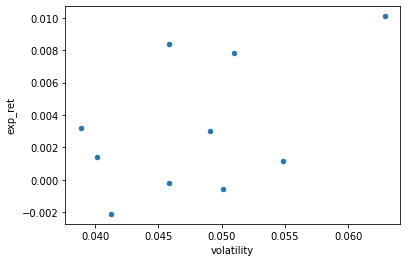

In [274]:
df_test.plot('volatility','exp_ret', kind = 'scatter')

In [277]:
df_test.loc[df_test['volatility']==df_test.volatility.min()]

,weight_x,weight_y,exp_ret,volatility
金风科技 与 同仁堂,0.504003,0.495997,0.003226,0.038853


In [247]:
np.sqrt(index_exp_var)

0.022253880915656367

# Monte-Carlo Simulation

In [248]:
number = 10000 #number of simulations
np.random.seed(123)

In [271]:
def simulation(ret_1, ret_2):
  exp_ret_1 = ret_1.mean()
  exp_ret_2 = ret_2.mean()
  var1 = np.var(ret_1)
  var2 = np.var(ret_2)
  cov = pd.Series.cov(ret_1,ret_2)

  # create a function to obtain the portfolio's variance
  def portfolio_risk(x, y):
    return np.power(x,2)*var1 + np.power(y,2)*var2 + 2*x*y*cov

  exp_return=[]
  volatility = []
  for i in range(number):
     random2 = np.random.random(2)
     random_weight = random2 / np.sum(random2)
     exp_ret_1 = ret_1.mean()
     exp_ret_2 = ret_2.mean()
     var1 = np.var(ret_1)
     var2 = np.var(ret_2)
     cov = pd.Series.cov(ret_1,ret_2)
     exp_return.append(random_weight[0]*exp_ret_1 + random_weight[1]*exp_ret_2)
     volatility.append(np.sqrt(portfolio_risk(random_weight[0], random_weight[1])))
  RandomPortfolios = pd.DataFrame({'exp_return':pd.Series(exp_return), 'volatility':pd.Series(volatility)})
  min_index = RandomPortfolios.volatility.idxmin()

  plt.figure(figsize=(100,100)) 
  RandomPortfolios.plot('volatility', 'exp_return', kind='scatter', alpha=0.3)
  x = round(RandomPortfolios.loc[min_index,'volatility'],6)
  y = round(RandomPortfolios.loc[min_index,'exp_return'],6)
  plt.scatter(x,y,color='red')
  plt.text(x,y,'({},{})'.format(x,y))
  plt.title(ret_1.name+" and "+ret_2.name)
  plt.show()
  

<Figure size 7200x7200 with 0 Axes>

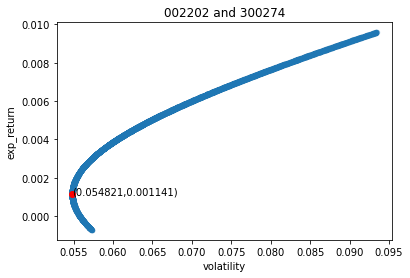

<Figure size 7200x7200 with 0 Axes>

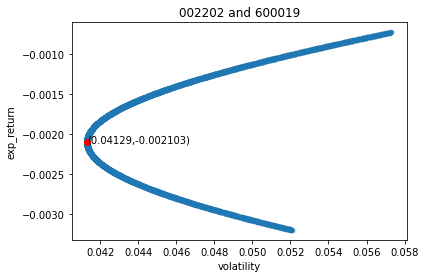

<Figure size 7200x7200 with 0 Axes>

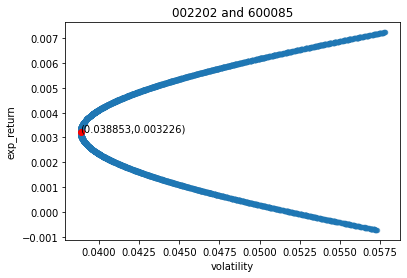

<Figure size 7200x7200 with 0 Axes>

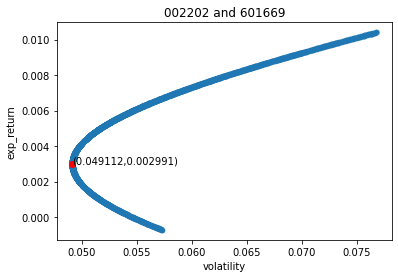

<Figure size 7200x7200 with 0 Axes>

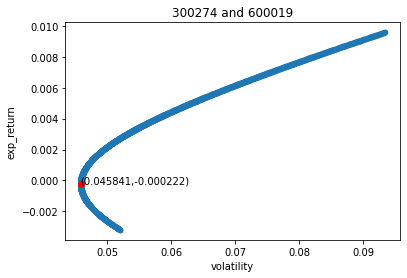

<Figure size 7200x7200 with 0 Axes>

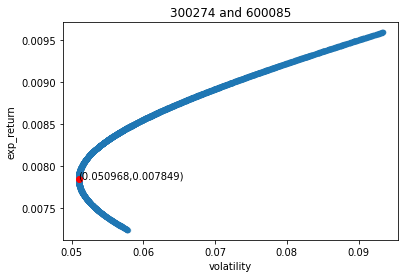

<Figure size 7200x7200 with 0 Axes>

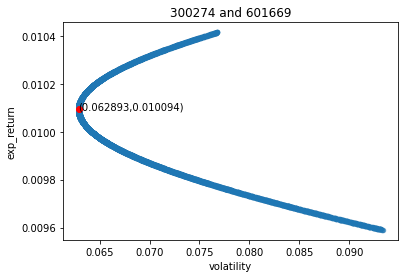

<Figure size 7200x7200 with 0 Axes>

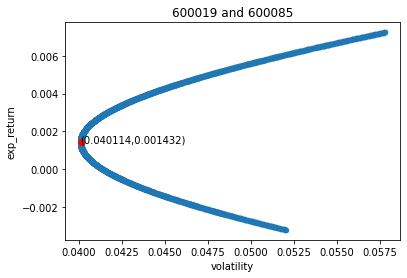

<Figure size 7200x7200 with 0 Axes>

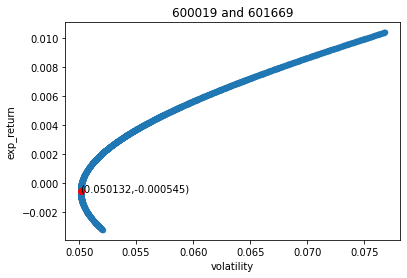

<Figure size 7200x7200 with 0 Axes>

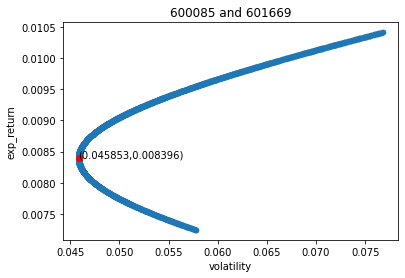

In [272]:
for j in range(1,5):
  for i in range(1,6-j):
    simulation(weekly_ret.iloc[:,j], weekly_ret.iloc[:,j+i])